### Imports

In [2]:
import kmapper as km
from kmapper.plotlyviz import *
import sklearn
# DBSCAN from sklearn for clustering algorithms
from sklearn.cluster import DBSCAN
# PCA from sklearn for projection/lens creation
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import RobustScaler,MinMaxScaler
import networkx as nx
import queue
import matplotlib.pyplot as plt

# Plotly and Dash
import plotly.graph_objs as go
import dash_html_components as html
import dash_core_components as dcc
import dash
from ipywidgets import interactive, HBox, VBox, widgets, interact
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pickle,json
from scipy import stats
from statsmodels.stats import multitest

### Functions

In [6]:
def cluster_fun(X, DBSCAN_EPSILON = 20, DBSCAN_MIN_SAMPLES = 1, N_CUBES = [7,7], PERC_OVERLAP = [.5,.5]):
    """

    """
    
    
#     keys = list(dict_df.keys())
#     print(keys)
#     X = dict_df.get(keys[0])
    # Killians interpolation naming for important columns
    kill = ["PREDICTED_WDP", "PREDICTED_SECCHI", "PREDICTED_TEMP", "PREDICTED_DO", 
           "PREDICTED_TURB","PREDICTED_COND", "PREDICTED_VEL", "PREDICTED_TP", 
           "PREDICTED_TN", "PREDICTED_SS", "PREDICTED_CHLcal"]
    
    # My interpolation naming for important columns
    my = ['PredictedTN','PredictedTP','TEMP','DO','TURB','COND','PredictedVEL','SS','WDP','CHLcal','SECCHI']
    nocond = ['PredictedTN','PredictedTP','TEMP','DO','TURB','PredictedVEL','SS','WDP','CHLcal','SECCHI']

    X = X[nocond]
    
    
    if X.shape[0]<DBSCAN_MIN_SAMPLES:
        #print(X)
        print("Not enough data to cluster in ", keys, "_size = ", X.shape[0])
        print("DBSCAN_MIN_SAMPLES", DBSCAN_MIN_SAMPLES)
        return([DBSCAN_MIN_SAMPLES, X.shape[0]])
    
    
    db = DBSCAN(eps=20, min_samples=2).fit(X)
    # Number of clusters in labels, ignoring noise if present.
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    return(db)

    
    
def mapper_pca_func(X,variables,color_variables=None, 
                    DBSCAN_EPSILON = 20, DBSCAN_MIN_SAMPLES = 1, N_CUBES = [125,125], PERC_OVERLAP = .4, num_pca=2,no_visual=False,
                    subfolder = "",title = "",verbosity = 0,gradient_colorscaling=None):
    """
    str(df_stratum_season_time_dict_list[1].keys())
    """
    
    # 
#     keys = list(dict_df.keys())
#     print(keys)
#     X = dict_df.get(keys[0])
    kill = ["PREDICTED_WDP", "PREDICTED_SECCHI", "PREDICTED_TEMP", "PREDICTED_DO", 
           "PREDICTED_TURB","PREDICTED_COND", "PREDICTED_VEL", "PREDICTED_TP", 
           "PREDICTED_TN", "PREDICTED_SS", "PREDICTED_CHLcal"]
    
    # My interpolation naming for important columns
    my = ['PredictedTN','PredictedTP','TEMP','DO','TURB','COND','PredictedVEL','SS','WDP','CHLcal','SECCHI']
    nocond = ['PredictedTN','PredictedTP','TEMP','DO','TURB','PredictedVEL','SS','WDP','CHLcal','SECCHI']

    X = X[variables]
    
    X.reset_index(drop=True,inplace = True)
    
    var_to_index = {variables[i] : i for i in range(len(variables))}
    projected_vars = variables
    projected_var_indices = [var_to_index[var] for var in projected_vars]
    
    if verbosity>0:
        print("X.shape: ",X.shape[0])
    

    # defining clustering and kmapper parameters
    
    # create instance of clustering alg
    cluster_alg = sklearn.cluster.DBSCAN(eps=DBSCAN_EPSILON, min_samples=DBSCAN_MIN_SAMPLES, metric='euclidean')

    # Instantiate kepler mapper object
    mapper = km.KeplerMapper(verbose=0)
    
    X_scaled = RobustScaler().fit_transform(X)
    
    # defining filter function as projection on to the first 2 component axis
    pca = PCA(n_components=num_pca)
    lens = pca.fit_transform(X_scaled)
    if(verbosity>0):
        print("Variance explained: ",pca.explained_variance_ratio_)
    
    # Project data onto the ones we want to display
    summary_variable = mapper.project(np.array(X),projection = projected_var_indices, scaler=None)
    
    # Generate the simplicial complex
    scomplex = mapper.map(lens, X_scaled, cover=km.Cover(n_cubes=N_CUBES, perc_overlap=PERC_OVERLAP), clusterer=cluster_alg,remove_duplicate_nodes=True)  

    if no_visual:
        return scomplex,X,X_scaled

    pl_brewer = [[0.0, '#006837'],
             [0.1, '#1a9850'],
             [0.2, '#66bd63'],
             [0.3, '#a6d96a'],
             [0.4, '#d9ef8b'],
             [0.5, '#ffffbf'],
             [0.6, '#fee08b'],
             [0.7, '#fdae61'],
             [0.8, '#f46d43'],
             [0.9, '#d73027'],
             [1.0, '#a50026']]

    if not color_variables:
        color_values = lens [:,0] - lens[:,0].min()
        
    else:
        
        if not gradient_colorscaling:
            # Do Caseys color scaling
            color_values = []
            for index,row in X.iterrows():
                color_values.append(get_color_vals(index,X,scomplex,color_variables))
        
        else:
            # Use amber and alainas color scaling - reassign outliers to ceiling
            for variable in color_variables:
                column_name = variable+"_color"
                q25, q75 = np.percentile(X[variable], [25, 75])
                iqr = q75 - q25

                ceiling = X[variable].quantile(.75) + (3 * iqr)

                X[column_name] = np.where(X[variable] >= ceiling, ceiling, water_df[variable])
    
            

    
    my_colorscale = pl_brewer
    
    kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                     color_values = color_values,  
                                                                     color_function_name=color_variables, 
                                                                     colorscale=my_colorscale)

    bgcolor = 'rgba(10,10,10, 0.9)'
    # y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey

    plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale, 
                                     factor_size=2.5, edge_linewidth=0.5)
    
    plot_title = title + str(DBSCAN_EPSILON) + str(DBSCAN_EPSILON) + ', MIN_SAMPLES ' + str(DBSCAN_MIN_SAMPLES)
    
#     # plot_title = 'Pool 13, Summer 1993-1999; Epsilon ' + str(DBSCAN_EPSILON) + ', MIN_SAMPLES ' + str(DBSCAN_MIN_SAMPLES) 
#     layout = plot_layout(title=plot_title,  
#                          width=620, height=570,
#                          annotation_text=get_kmgraph_meta(mapper_summary),  
#                          bgcolor=bgcolor)
    
#     # FigureWidget is responsible for event listeners

# #     fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
# #     fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor)
# #     fw_summary = summary_fig(mapper_summary, height=300)

#     dashboard = hovering_widgets(kmgraph, 
#                                  fw_graph, 
#                                  bgcolor=bgcolor, 
#                                  member_textbox_width=600)

    # DESIRED FILE PATH, CHANGE TO FIT YOUR LOCAL MACHINE
    directory_path = r"Mapper outputs"
    
    #Update the fw_graph colorbar, setting its title:
    #fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'
    html_output_path = directory_path + "\\"+ subfolder + title + 'PCA_'+str(num_pca) + 'all_var_' + 'Eps_' + str(DBSCAN_EPSILON) +'MinS_' + str(DBSCAN_MIN_SAMPLES) + 'NCUBES_' + str(N_CUBES) + 'PEROvLp_' + str(PERC_OVERLAP) + '.html'
    html_output_path = html_output_path.replace(":","_")
    mapper.visualize(scomplex, path_html=html_output_path, color_values=color_values, color_function_name=color_function_name,lens=summary_variable,lens_names=projected_vars)
    return scomplex, X, X_scaled,mapper_summary


def getSubdf(scomplex, shape, df):
    """
    Returns the part of the data frame from the particular shape in the simplicial complex.
    params:
    scomplex: the entire simplicial complex
    shape: the particular shape being inspected (within the simplicial complex) list of node names
    df: the entire data frame
    
    Description:
    1. Get all the nodes from the particular simplicial complex. 
    2. Generate the indices we care about from the particular shape. To do this, we read each node and append it's 
    indices to a list. Then, we convert the list to a set and then back to a list to eliminate duplicates.
    3. Return the dataframe with only those indices.
    """
    nodes = scomplex.get('nodes')
    indices = []
    npShape = np.array(shape).flatten()
    for node in npShape:
        indices.append(nodes.get(node))
    indices = list(set([item for sublist in indices for item in sublist]))
    subdf = df.loc[indices]
    return subdf

def shapeDataSummary(scomplex, shape, df, variables, verbose = False):
    """
    Generates summary statistics of the given variables for a given shape in the simplicial.
    params:
    scomplex: the entire simplicial complex
    shape: the particular shape being inspected (within the simplicial complex) at this function call.
    df: the entire dataframe
    variables: the variables of interest
    verbose: Determines if the function will print out extra information. False by default
    
    Description:
    1. Create an empty result dataframe to store the summary statistics.
    2. Get the sub dataframe (see getSubdf) for the particular shape
    3. For each variable we are analzying, generate summary statistics from the sub dataframe and place them
    inside the result dataframe.
    4. Return the result dataframe
    
    NOTE: this only creates summaries for one particular shape. In executing this method, it is done for each shape 
    outside of the function.
    
    """
    result = pd.DataFrame()
    if verbose == True:
        print("Obtaining sub dataframe for: ", shape)
        print("The number of nodes in this shape is: ", len(shape))
    subdf = getSubdf(scomplex, shape, df)
    if verbose == True:
        print("The number of datapoints in this shape is: ", subdf.shape[0])
    for var in variables:
        result[var] = subdf[var].describe()
    return result
    
    

def adjacent(v, scomplex):
    """
    Determines the nodes adjacent to a given vertex
    
    params:
    v: vertex
    scomlex: the entire simplicial complex
    
    Description:
    Determines the nodes that are adjacent to a given vertex.
    """
    
    simplices = scomplex.get('simplices')
    edges = [item for item in simplices if len(item) == 2]
    result = []
    for edge in edges:
        if v in edge:
            for item in edge:
                if item != v:
                    result.append(item)
    return result

def bfs(node, scomplex):
    """
    Conducts a breadth first search to obtain the entire shape from a given node
    params:
    node: the start node
    scomplex: the entire simplicial complex
    
    Description:
    Preforms a breadth first search to obtain the entire shape for a given start node.
    """
    Q = queue.Queue()
    result = []
    result.append(node)
    Q.put(node)
    while not Q.empty():
        v = Q.get()
        adjacentEdges = adjacent(v, scomplex)
        for edge in adjacentEdges:
            if edge not in result:
                result.append(edge)
                Q.put(edge)
    return result


        
    
def getShapes(scomplex):
    """
    Gets all of the shapes from a given simplicial complex.
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Obtain all the nodes for the entire complex
    2. For each node, preform a breadth first search to obtain everything in that particular shape. 
    If this entire shape has not already been discovered, add it to the set of results. 
    The result item is a set as the order of the shapes does not matter. The resulting shape is a frozenset
    which means items cannot be added or removed once created, and is needed to allow the set object to have other sets within it.
    3. Convert each shape to a list and the result to a list for easier navigation outside of the function.
    4. Return the result
    
    """
    
    nodes = list(scomplex.get('nodes').keys())
    result = set()
    for node in nodes: # currently does more computations than necessary due to going through every node without considering it is already in a shape
        bfsResult = frozenset(bfs(node, scomplex))
        result.add(bfsResult)
    result = [list(x) for x in result]
    # Sort the list depending on what is decided: nodes or indices. Currently doing it by number of nodes
    result.sort(key = len, reverse = True)
    
    
    
    return result

def nodeDataSummary(node, scomplex, variables,df):
    """
    Returns a data summary of a particular node
    params:
    node: node in question
    scomplex: The entire simplicial complex
    variables: The variables to obtain summaries
    df: the entire dataframe 
    
    description:
    1. Creates a result dataframe
    2. Get all the indices from the node from the simplicial complex
    3. Generate summaries for each variable
    4. Return the result
    """
    result = pd.DataFrame()
    if isinstance(node, list):
        print("Node is a list and thus cannot get summary information: ", node)
        indices = scomplex.get('nodes').get(node[0])
        subdf = df.loc[indices]
        for var in variables:
            result[var] = subdf[var].describe()
        return result
    
        
    indices = scomplex.get('nodes').get(node)
    subdf = df.loc[indices]
    for var in variables:
        result[var] = subdf[var].describe()
    return result
    
    
def condenseShape(shape, scomplex):
    """
    
    params:
    shape: a shape of two nodes. must be 2
    scomplex: the entire simplicial complex
    
    description:
    gets the two nodes a and b
    gets the indices for a and b (what is inside the nodes)
    if a \subseteq b, return b
    elif b \subseteq a, return a 
    else return shape 
    
    """
    nodes = scomplex.get('nodes')
    a = shape[0]
    b = shape[1]
    aIndices = set(nodes.get(a))
    bIndices = set(nodes.get(b))
    
    if aIndices.issubset(bIndices):
        return b
    elif bIndices.issubset(aIndices):
        return a
    else:
        return shape

def clean_getShapes(scomplex):
    """
    Condenses 1-simplices down to 0-simplices when each node 
    is a subset of the other 
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Get all the shapes from the original getShapes function
    2. For shapes that of length 2, if one is a subset of the other, return the larger of the two
        Otherwise, do nothing
    3. return the clean Shapes list 
    
    """
    shapes = getShapes(scomplex)
    cleanShapes = []
    for shape in shapes:
        if len(shape) == 2:
            shape = condenseShape(shape, scomplex)
            cleanShapes.append([shape])
        else:
            cleanShapes.append(shape)
    return cleanShapes


def getBoxplots(subdf, shape, key,filePath):
    """
    Generates box plots for 10 of the 11 continuous variables
    NOTE: CONDUCTIVITY IS NOT INCLUDED
    
    params:
    subdf: the sub dataframe of the particular shape
    shape: the shape in question
    key: what strata year season combo we are looking at 
    filePath: the output file path for all the box plots 
    
    description:
    clears the current plot 
    generates the sub dataframes for the respective variables.
    the reason they are grouped is based upon the numerical outputs for making the boxplots readable
    create a box plot, and then save it based upon the file path
    clear the plot
    repeat for the second set of variables
    """
    plt.clf()
    varDf1 = subdf[["PREDICTED_SS","PREDICTED_TURB","PREDICTED_TEMP","PREDICTED_CHLcal","PREDICTED_SECCHI"]]
    varDf2 = subdf[["PREDICTED_TP","PREDICTED_TN","PREDICTED_DO","PREDICTED_VEL","PREDICTED_WDP"]]
    plot1 = varDf1.boxplot(rot = 45)
    plt.savefig(filePath + "\\" + key +"_" + str(shape)  + "_SS_TURB_CHLcal"  + ".png")
    plt.clf()
    plot2 = varDf2.boxplot(rot = 45)
    plt.savefig(filePath + "\\" + key +"_" + str(shape)  + "_" + "TP_TN_VEL_etc" + ".png")
    return plot1, plot2

def determineOverlap(scomplex, shape, verbose = True):
    """
    Determines the overlap within a shape. 
    
    For each node, find it's neighbors, and generate the intersection, and saving the result without
    duplicates through utlizing the set functionality of python.
    
    params:
    scomplex: the entire simplicial complex in question
    shapes: all the shapes
    verbose: see prinout as the code works
    """
    
    result = set()
    if verbose:
        print("Shape: ", shape)
    nodes = scomplex.get('nodes')
    for node in shape:
        # currently, this displays a lot of repeats. 
        A = set(nodes.get(node))
        if verbose:
            print("Node: " , node  , " | Indices: ",A)
        B = adjacent(node, scomplex)
        if verbose:
            print("Adjacent nodes: ",B)
        for b in B:
            bSet = set(nodes.get(b))
            name = str(node) + " -> " + str(b) +": "
            intersection = set(A.intersection(bSet))
            intersection.add(name)
            intersection = frozenset(intersection)
            result.add(intersection)
            if verbose:
                print("Node: ", b, " | Indices: ", bSet)
                print("Overlap is: ", A.intersection(bSet))
    return result


def k_nearest_neighbors(df, neigh, point, k):
    return neigh.kneighbors([list(df.loc[point])], k)[0].flatten()
    
def calculate_density(scomplex, node, df, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df)
    knn = 0
    n = len(scomplex['nodes'][node])
    for point in scomplex['nodes'][node]:
        distances = k_nearest_neighbors(df, neigh, point, k)
        knn += (sum(distances) / k)
    density = knn / (n*n)
    return (1.0 / density)

def generate_graph(scomplex, shape):
    dg = generate_nodes(scomplex, shape)
    dg = generate_edges(scomplex, shape, dg)
    return dg

def generate_nodes(scomplex, shape):
    dg = nx.DiGraph()
    dg.add_nodes_from(shape)
    return dg

def generate_edges(scomplex, shape, dg):
    for node in shape:
        if node in scomplex['links']:
            for adjacent_node in scomplex['links'][node]:
                if scomplex['density'][node] < scomplex['density'][adjacent_node]:
                    dg.add_edge(node, adjacent_node)
                else:
                    dg.add_edge(adjacent_node, node)
    return dg

def get_local_maxima(dg):
    maxima = []
    for node in list(dg.nodes):
        succ = dict(nx.bfs_successors(dg, source=node))
        if not succ[node]:
            maxima.append(node)
    return maxima

def draw_graph(scomplex, filepath, with_labels=False,save= True):
    colors = ['#66664D', '#991AFF', '#E666FF', '#4DB3FF', '#1AB399',
		  '#E666B3', '#33991A', '#CC9999', '#B3B31A', '#00E680', 
		  '#4D8066', '#809980', '#E6FF80', '#1AFF33', '#999933',
		  '#FF3380', '#CCCC00', '#66E64D', '#4D80CC', '#9900B3', 
		  '#E64D66', '#4DB380', '#FF4D4D', '#99E6E6', '#6666FF']
    colors_dict = {scomplex['maxima'][i] : colors[i] for i in range(len(scomplex['maxima']))}
    transition_color = '#ffff00'
    color_map = []
    scomplex['states'] = {scomplex['maxima'][i] : [] for i in range(len(scomplex['maxima']))}
    
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(111)
    ax.set_title('Graph - Shapes', fontsize=72)
    
    for node in scomplex['graph']:
        distDict = {scomplex['maxima'][i] : graph_distance(scomplex['graph'], node, scomplex['maxima'][i])
                    for i in range(len(scomplex['maxima']))}
        minDist = min(distDict.values())
        states = [maxima if distDict[maxima] == minDist else None for maxima in scomplex['maxima']]
        states = list(filter(None, states))
        
        for state in states:
            scomplex['states'][state].append(node)
        
        if len(states) > 1:
            color_map.append(transition_color)
        else:
            color_map.append(colors_dict[states[0]])

    
    nx.draw_kamada_kawai(scomplex['graph'], with_labels=with_labels, node_color=color_map)
    plt.tight_layout()
    if save:
        plt.savefig(filepath, format="PNG")
    plt.show()

def graph_distance(dg, source, target):
    if nx.has_path(dg, source, target):
        return len(nx.shortest_path(dg, source, target))
    return float('inf')


def getNodesfromIndex(scomplex, index):
    """
    docstring to write later
    """
    result = set()
    nodes = scomplex['nodes']
    nodesList = list(scomplex['nodes'].keys())
    for node in nodesList:
        if index in nodes[node]:
            result.add(node)
    
    return list(result)


def get_color_vals(index,df,scomplex,variables):
    """
    Gets the new color value assignment for this row
    """
    relevant_nodes = getNodesfromIndex(scomplex,index)
    
    #print(relevant_nodes)
    
    relevant_df = getSubdf(scomplex,relevant_nodes,df)
    
    colorvals = relevant_df[variables].mean()
    
    return list(colorvals)


def output_density_graph(scomplex,X_scaled,title = "random_title"+str(int(100*round(np.random.rand(),3))),verbosity = 0):
    '''
    Does the work for outputting the number of states and directed graph
    '''
    
    scomplex["density"] = {}

    largestShape = np.array(clean_getShapes(scomplex)[0]).flatten()
    if verbosity>0:
        print("Largest shape is: ",largestShape, "\n")
    Y = pd.DataFrame(X_scaled)
    largestShape_df = getSubdf(scomplex,largestShape,Y)
    k = int(round(X_scaled.shape[0]/10,0))
    for node_name in largestShape:
        if verbosity>0:
            print("Node Name: ",node_name)
        scomplex["density"][node_name] = calculate_density(scomplex,node_name,largestShape_df,k)
        
        
    scomplex['graph'] = generate_graph(scomplex,largestShape)
    scomplex['maxima'] = get_local_maxima(scomplex['graph'])
    print("Maximum: ", scomplex['maxima'])
    print("Number of states: ",len(scomplex['maxima']))
    filepath = r"Mapper outputs\Directed Graphs" + "\\" +title+".png"
    draw_graph(scomplex,filepath,with_labels=False)
    
    return scomplex

print("Functions loaded")

Functions loaded


### Load data

Run this cell to use Ambers Random Forrest interpolated dataset

In [39]:
continuous = ['TN','TP','TEMP','DO','TURB','COND','VEL','SS','WDP','CHLcal','SECCHI']
nocond = ['TN','TP','TEMP','DO','TURB','VEL','SS','WDP','CHLcal','SECCHI']

seasons = {3:"SPRING",4:"SPRING",5:"SPRING",6:"SUMMER",7:"SUMMER",8:"SUMMER",9:"FALL",10:"FALL",11:"FALL",12:"WINTER",1:"WINTER",2:"WINTER"}

water_data = pd.read_csv(r"..\..\LTRM data\RF interpolation\water_combinedcols.csv")

print("Now adding a month column")
water_data["MONTH"] = pd.DatetimeIndex(water_data["DATE"]).month
print("Now adding a season column")
water_data["SEASON"] = water_data["MONTH"]
water_data = water_data.replace({"SEASON":seasons})
print("Filtering by pool 13")
water_data = water_data[water_data["FLDNUM"]=="Bellevue, IA"].reset_index(drop=True)
print(water_data.columns)
water_data.dropna(axis=0, how='any', thresh=None, subset=nocond, inplace=True)
water_data.shape

Now adding a month column
Now adding a season column
Filtering by pool 13
Index(['SHEETBAR', 'DATE', 'LATITUDE', 'LONGITUDE', 'FLDNUM', 'STRATUM',
       'LOCATCD', 'TN', 'TP', 'TEMP', 'DO', 'TURB', 'COND', 'VEL', 'SS', 'WDP',
       'CHLcal', 'SECCHI', 'YEAR', 'SEASON', 'MONTH'],
      dtype='object')


(14749, 21)

### Check explained variance ratio to determine n_cubes ratio on pca

In [41]:
X = water_data[nocond]
    
X.reset_index(drop=True,inplace = True)
X_scaled = RobustScaler().fit_transform(X)
    
# defining filter function as projection on to the first 2 component axis
pca = PCA(n_components=2)
lens = pca.fit_transform(X_scaled)
print("Variance explained: ",pca.explained_variance_ratio_)
variance_ratio = pca.explained_variance_ratio_[0]/pca.explained_variance_ratio_[1]
print("Variance ratio ",variance_ratio)

Variance explained:  [0.42558743 0.15246397]
Variance ratio  2.791396764842063


### Test parameters largest node and data retention

In [44]:
num_rows = water_data.shape[0]
perc_overlap_list = [0.15,0.25,0.35,0.45,0.55]
n_cubes_list = [[30,int(30//variance_ratio)],[50,int(50//variance_ratio)],[70,int(70//variance_ratio)],[90,int(90//variance_ratio)],
                [110,int(110//variance_ratio)],[130,int(130//variance_ratio)]]

min_samples = 20
# From elbow curve
epsilon = 1.8

for perc_overlap in perc_overlap_list:
    for n_cubes in n_cubes_list:
        strnum = str(int(perc_overlap*100))
        
        subfolder = "Shape persistence\\perc_"+strnum+"\\"
        scomplex,X,X_scaled,mapper_summary = mapper_pca_func(water_data,nocond,color_variables=nocond,color_function_name = nocond,N_CUBES=n_cubes,
                       PERC_OVERLAP = perc_overlap,DBSCAN_MIN_SAMPLES = min_samples,DBSCAN_EPSILON=epsilon,num_pca = 2,
                       subfolder = subfolder)
        
        max_size = max([len(scomplex['nodes'][node]) for node in scomplex['nodes']])
        samples_used = mapper_summary['n_unique']
        
        
        print("---------")
        print(str(perc_overlap)+" "+str(n_cubes))
        print("Largest node is "+str(round(max_size/num_rows,4))+" of entire data")
        print("Retained "+str(round(samples_used/num_rows,4))+" of entire data")

---------
0.15 [30, 10]
Largest node is 0.4878 of entire data
Retained 0.9786 of entire data
---------
0.15 [50, 17]
Largest node is 0.3082 of entire data
Retained 0.975 of entire data
---------
0.15 [70, 25]
Largest node is 0.1789 of entire data
Retained 0.9693 of entire data
---------
0.15 [90, 32]
Largest node is 0.1187 of entire data
Retained 0.9581 of entire data
---------
0.15 [110, 39]
Largest node is 0.0873 of entire data
Retained 0.9498 of entire data
---------
0.15 [130, 46]
Largest node is 0.0607 of entire data
Retained 0.9364 of entire data
---------
0.25 [30, 10]
Largest node is 0.5549 of entire data
Retained 0.9805 of entire data
---------
0.25 [50, 17]
Largest node is 0.3622 of entire data
Retained 0.9771 of entire data
---------
0.25 [70, 25]
Largest node is 0.2174 of entire data
Retained 0.9746 of entire data
---------
0.25 [90, 32]
Largest node is 0.1472 of entire data
Retained 0.9683 of entire data
---------
0.25 [110, 39]
Largest node is 0.1075 of entire data
Retain

### The chosen parameters for pool 13 are perc_overlap = 0.25 and n_cubes = [130,46]. It displays a representative shape and the largest node contains 7.73% of the data and 95% of the data is retained.

Save the output of pool 13 with thes parameters in a tuple, then pickle it

In [57]:
n_cubes = [130,46]
perc_overlap = 0.25
min_samples = 20
epsilon = 1.8
nocond = ['TN','TP','TEMP','DO','TURB','VEL','SS','WDP','CHLcal','SECCHI']

scomplex,X,X_scaled = mapper_pca_func(water_data,nocond,color_variables=nocond,N_CUBES=n_cubes,
                       PERC_OVERLAP = perc_overlap,DBSCAN_MIN_SAMPLES = min_samples,DBSCAN_EPSILON=epsilon,num_pca = 2,
                       subfolder = subfolder,no_visual=True)

output_tuple = (scomplex,X,X_scaled)
pickle.dump(output_tuple,open("output_tuple.p",'wb'))

### Load output of selected parameters

In [4]:
output_tuple = pickle.load(open("output_tuple.p",'rb'))
scomplex = output_tuple[0]
X = output_tuple[1]
X_scaled = output_tuple[2]

### Get directed graph and number of states

Maximum:  ['cube15_cluster0', 'cube57_cluster0']
Number of states:  2


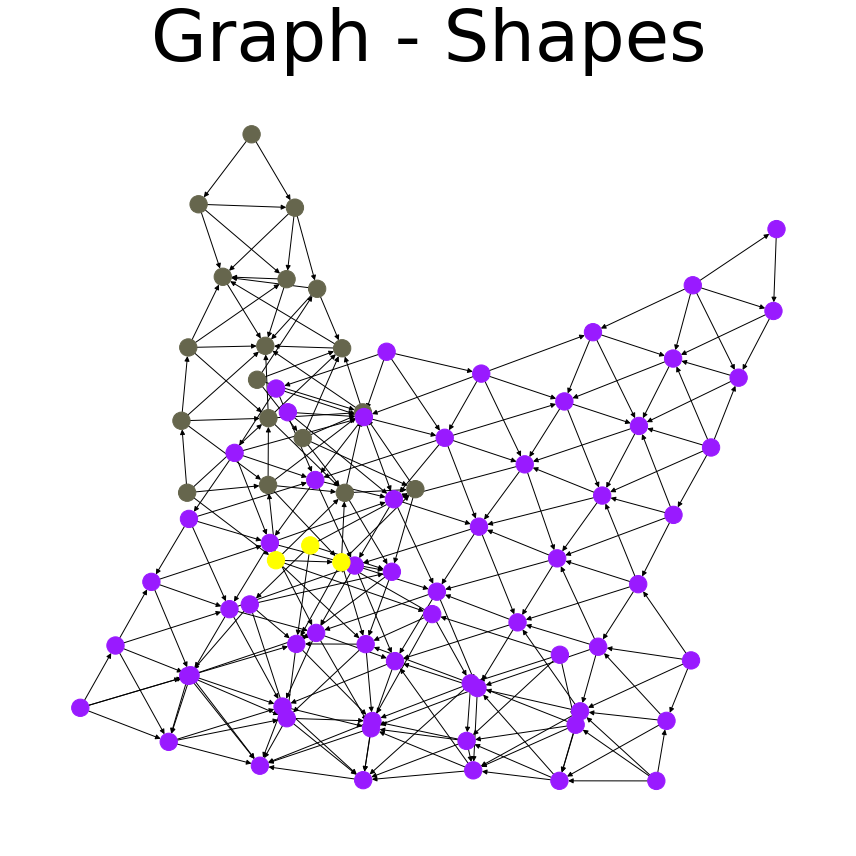

In [5]:
title = "Pool13_directed"
scomplex = output_density_graph(scomplex,X_scaled,title)

Count the number of points in each state

In [69]:
for state in scomplex['maxima']:
    df = getSubdf(scomplex, scomplex['states'][state], X)
    print("Number of points in "+str(state)+" is ",df.shape[0])

Number of points in cube57_cluster0 is  11384
Number of points in cube15_cluster0 is  3322


### Boxplot comparison for each variable

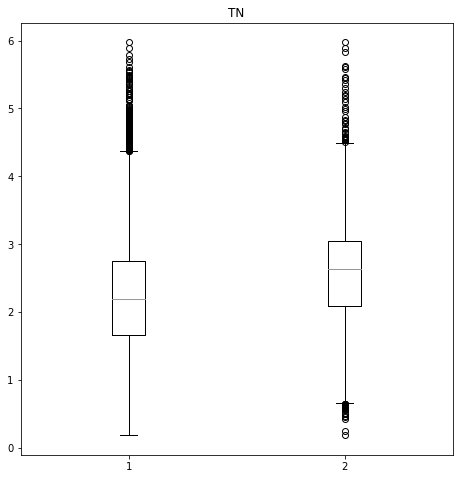

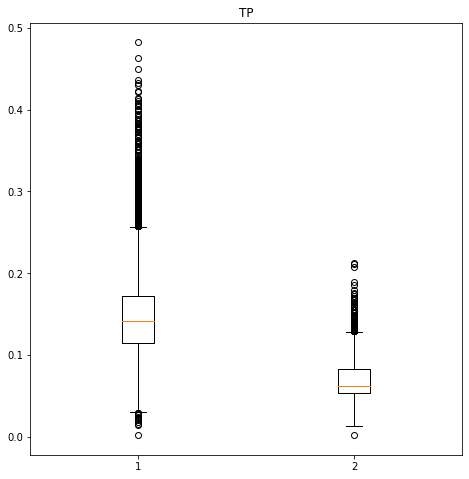

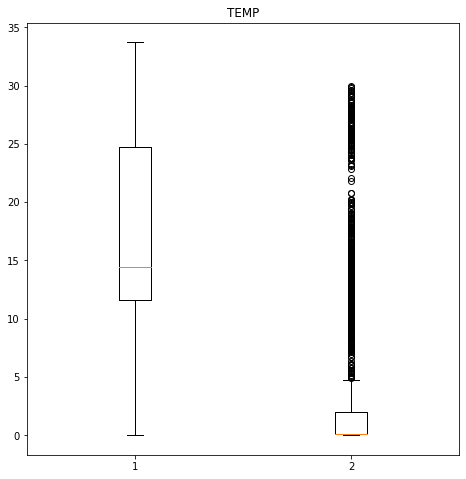

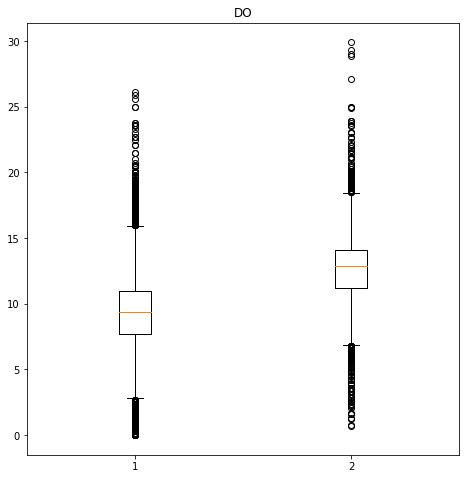

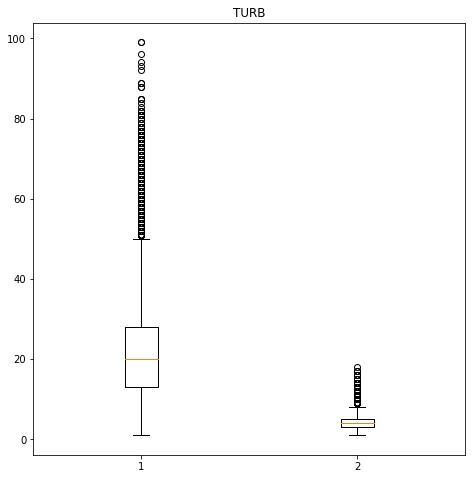

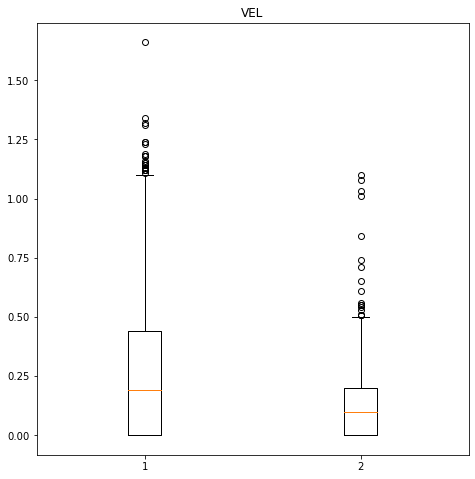

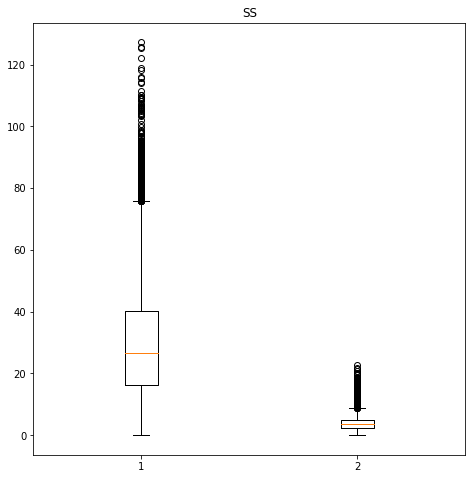

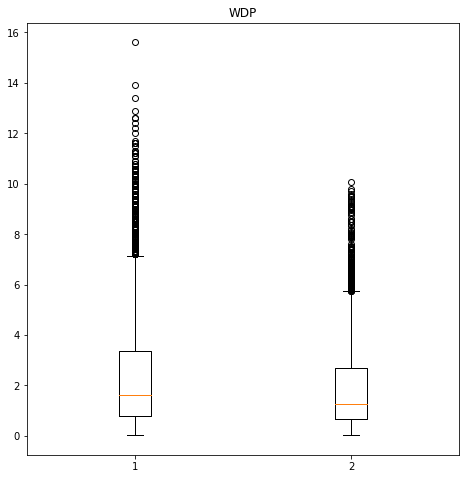

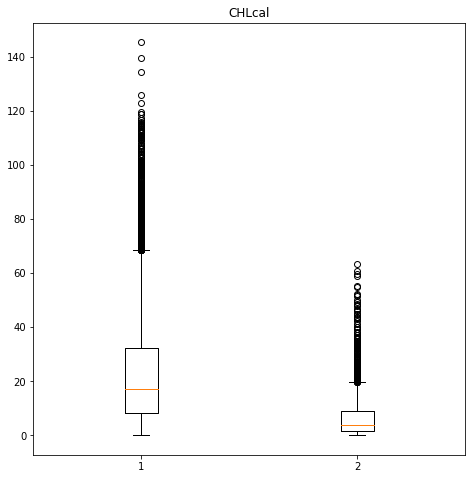

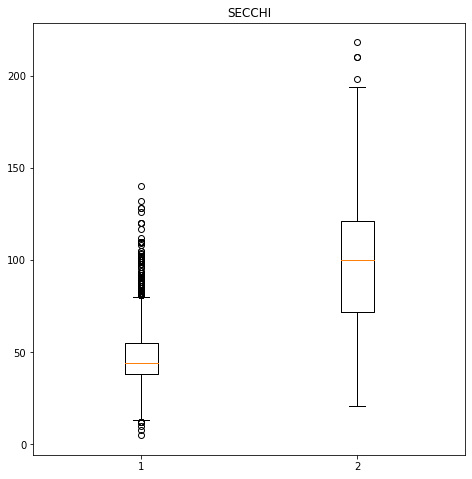

In [92]:
# Get data from each state
state1 = getSubdf(scomplex,scomplex['states']['cube57_cluster0'],X)
state2 = getSubdf(scomplex,scomplex['states']['cube15_cluster0'],X)

for variable in X.columns:
    state1data = state1[variable]
    state2data = state2[variable]
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_axes([0,0,1,1])
    bp = ax.boxplot([state1data,state2data])
    plt.title(str(variable))
    ax.figure.savefig("Boxplots\\Pool 13"+variable,bbox_inches="tight",dpi=150)

### Checking out wierd plot with temp

<AxesSubplot:ylabel='Density'>

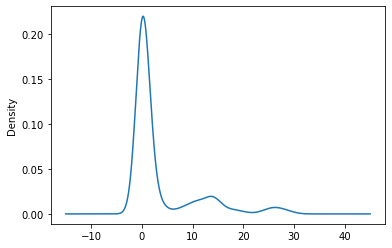

In [95]:
state2['TEMP'].plot.density()